In [50]:
## Libraries:

# a) Bond graphs
import BondGraphTools as bgt

# b) Data extraction
import rdflib
from lxml import etree
import pandas
import re
import xml.etree.ElementTree as ET
import os

# c) General
import copy
import difflib
import numpy as np
import math

# d) Plot
import matplotlib.pyplot as plt
from matplotlib import markers
import matplotlib.font_manager as font_manager
import matplotlib.colors
from pylab import rcParams

# Integration and fitting
from scipy.optimize import curve_fit, minimize, least_squares, newton_krylov
from scipy.integrate import odeint
import scipy.stats as stats
from symfit import parameters, variables, log, Fit, GreaterThan
from symfit.core.minimizers import BasinHopping

In [51]:
data=pandas.read_csv('kholodenko_allReversibles_data.csv') 
Data={}
cellmlKinetics={}
labels=[]
for label in data:
    labels.append(label)
    Data[label]=[] 
    Data[label].append(data[label])
# labels for cellml kinetics
for label in labels:
    for cell in Data[label]:
        cellmlKinetics[label]=[]  
        for c in cell:
            cellmlKinetics[label].append(c)


In [52]:
# Later by detecting the annotations for "Forward" and "Backward" affinities!
# flows = v1, v2, ...
# concentrations = R, EGF, R2, ...
# forwardAffinities = k1, k2, ...
# backwardAffinities = k1_, k2_, ...

time= cellmlKinetics['environment | time (second)']
flows=[]; concentrations=[]; forwardAffinities=[];  backwardAffinities=[];
for l in labels:
    if '(flux)' in l:
        flows.append(l)
    elif '(nanomolar)' in l:
        concentrations.append(l)

for i in range(1,26):
    if i == 4 or i == 8 or i == 16:
        pass
    else:
        for l in labels:
            if 'k'+str(i)+'_' in l:
                backwardAffinities.append(l)
            elif 'k'+str(i)+' ' in l:
                forwardAffinities.append(l)
                

In [53]:
# Model creation 
model=bgt.new(name='EGFR')
idealGassConstant=8.314

T= 310
x_ATP = 266223397.15758723e3; x_ADP = 1e3; x_P = 1e3
k_ATP = 1e-3; k_ADP = 1e-3; k_P = 1e-3

# Substrates
R = bgt.new("Ce", name=concentrations[13], library="BioChem", value={'R':idealGassConstant, 'T':T})
EGF = bgt.new("Ce", name=concentrations[7], library="BioChem", value={'R':idealGassConstant, 'T':T})
Ra = bgt.new("Ce", name=concentrations[23], library="BioChem", value={'R':idealGassConstant, 'T':T})
stoi2 = bgt.new("TF", name =concentrations[23] , value=2)
R2 = bgt.new("Ce", name=concentrations[14], library="BioChem", value={ 'R':idealGassConstant, 'T':T})
RP = bgt.new("Ce", name=concentrations[24], library="BioChem", value={'R':idealGassConstant, 'T':T})
R_PL = bgt.new("Ce", name=concentrations[17], library="BioChem", value={'R':idealGassConstant, 'T':T})
R_PLP = bgt.new("Ce", name=concentrations[18], library="BioChem", value={'R':idealGassConstant, 'T':T})
PLC_gamma = bgt.new("Ce", name=concentrations[10], library="BioChem", value={'R':idealGassConstant, 'T':T})
PLC_gamma_P = bgt.new("Ce", name=concentrations[11], library="BioChem", value={'R':idealGassConstant, 'T':T})
PLC_gammaPI = bgt.new("Ce", name=concentrations[12], library="BioChem", value={'R':idealGassConstant, 'T':T})
Grb = bgt.new("Ce", name=concentrations[9], library="BioChem", value={'R':idealGassConstant, 'T':T})
Shc = bgt.new("Ce", name=concentrations[27], library="BioChem", value={'R':idealGassConstant, 'T':T})
SOS = bgt.new("Ce", name=concentrations[29], library="BioChem", value={'R':idealGassConstant, 'T':T})
Sh_G = bgt.new("Ce", name=concentrations[25], library="BioChem", value={'R':idealGassConstant, 'T':T})
ShP = bgt.new("Ce", name=concentrations[28], library="BioChem", value={ 'R':idealGassConstant, 'T':T})
G_S = bgt.new("Ce", name=concentrations[8], library="BioChem", value={'R':idealGassConstant, 'T':T})
ShGS = bgt.new("Ce", name=concentrations[26], library="BioChem", value={'R':idealGassConstant, 'T':T})
R_ShGS = bgt.new("Ce", name=concentrations[21], library="BioChem", value={'R':idealGassConstant, 'T':T})
R_ShG = bgt.new("Ce", name=concentrations[20], library="BioChem", value={'R':idealGassConstant, 'T':T})
R_ShP = bgt.new("Ce", name=concentrations[22], library="BioChem", value={'R':idealGassConstant, 'T':T})
R_Sh = bgt.new("Ce", name=concentrations[19], library="BioChem", value={'R':idealGassConstant, 'T':T})
R_GS = bgt.new("Ce", name=concentrations[16], library="BioChem", value={'R':idealGassConstant, 'T':T})
R_G = bgt.new("Ce", name=concentrations[15], library="BioChem", value={'R':idealGassConstant, 'T':T})
#!Update: Used Se components 
ATP = bgt.new("Se", name='ATP', value={'e': 50000})
ADP = bgt.new("Se", name='ADP', value={'e': 0})

# Reactions

Re1 = bgt.new("Re", name=flows[0], library="BioChem", value={'R':idealGassConstant, 'T':T})
Re2 = bgt.new("Re", name=flows[10], library="BioChem", value={'R':idealGassConstant, 'T':T})
Re3 = bgt.new("Re", name=flows[17] , library="BioChem", value={'R':idealGassConstant, 'T':T})
Re5 = bgt.new("Re", name=flows[18] , library="BioChem", value={'R':idealGassConstant, 'T':T})
Re6 = bgt.new("Re", name=flows[19] , library="BioChem", value={'R':idealGassConstant, 'T':T})
Re7 = bgt.new("Re", name=flows[20] , library="BioChem", value={'R':idealGassConstant, 'T':T})
Re9 = bgt.new("Re", name=flows[21] , library="BioChem", value={'R':idealGassConstant, 'T':T})
Re10 = bgt.new("Re", name=flows[1], library="BioChem", value={'R':idealGassConstant, 'T':T})
Re11 = bgt.new("Re", name=flows[2], library="BioChem", value={'R':idealGassConstant, 'T':T})
Re12 = bgt.new("Re", name=flows[3], library="BioChem", value={'R':idealGassConstant, 'T':T})
Re13 = bgt.new("Re", name=flows[4], library="BioChem", value={'R':idealGassConstant, 'T':T})
Re14 = bgt.new("Re", name=flows[5], library="BioChem", value={'R':idealGassConstant, 'T':T})
Re15 = bgt.new("Re", name=flows[6], library="BioChem", value={'R':idealGassConstant, 'T':T})
Re17 = bgt.new("Re", name=flows[7], library="BioChem", value={'R':idealGassConstant, 'T':T})
Re18 = bgt.new("Re", name=flows[8], library="BioChem", value={ 'R':idealGassConstant, 'T':T})
Re19 = bgt.new("Re", name=flows[9], library="BioChem", value={'R':idealGassConstant, 'T':T})
Re20 = bgt.new("Re", name=flows[11], library="BioChem", value={'R':idealGassConstant, 'T':T})
Re21 = bgt.new("Re", name=flows[12], library="BioChem", value={ 'R':idealGassConstant, 'T':T})
Re22 = bgt.new("Re", name=flows[13], library="BioChem", value={'R':idealGassConstant, 'T':T})
Re23 = bgt.new("Re", name=flows[14], library="BioChem", value={ 'R':idealGassConstant, 'T':T})
Re24 = bgt.new("Re", name=flows[15], library="BioChem", value={'R':idealGassConstant, 'T':T})
Re25 = bgt.new("Re", name=flows[16], library="BioChem", value={'R':idealGassConstant, 'T':T})

# Junctions 

zeroJunc_R = bgt.new("0", name=concentrations[13])
zeroJunc_EGF = bgt.new("0", name = concentrations[7])
zeroJunc_Ra = bgt.new("0", name = concentrations[23])
zeroJunc_R2 = bgt.new("0", name = concentrations[14])
zeroJunc_RP = bgt.new("0", name = concentrations[24])
zeroJunc_R_PL = bgt.new("0", name = concentrations[17])
zeroJunc_R_PLP = bgt.new("0", name = concentrations[18])
zeroJunc_PLC_gamma = bgt.new("0", name = concentrations[10])
zeroJunc_PLC_gamma_P = bgt.new("0", name = concentrations[11])
zeroJunc_PLC_gammaPI = bgt.new("0", name = concentrations[12])
zeroJunc_Grb = bgt.new("0", name = concentrations[9])
zeroJunc_Shc = bgt.new("0", name = concentrations[27])
zeroJunc_SOS = bgt.new("0", name = concentrations[29])
zeroJunc_ShGS = bgt.new("0", name = concentrations[26])
zeroJunc_Sh_G = bgt.new("0", name = concentrations[25])
zeroJunc_ShP = bgt.new("0", name = concentrations[28])
zeroJunc_G_S = bgt.new("0", name = concentrations[8])
zeroJunc_R_ShGS = bgt.new("0", name = concentrations[21])
zeroJunc_R_ShG = bgt.new("0", name = concentrations[20])
zeroJunc_R_ShP = bgt.new("0", name = concentrations[22])
zeroJunc_R_Sh = bgt.new("0", name = concentrations[19])
zeroJunc_R_GS = bgt.new("0", name = concentrations[16])
zeroJunc_R_G = bgt.new("0", name = concentrations[15])
zeroJunc_ATP = bgt.new("0", name = 'ATP')
zeroJunc_ADP = bgt.new("0", name = 'ADP')


oneJunc_1_reac = bgt.new("1", name=forwardAffinities[0]); oneJunc_1_prod = bgt.new("1", name=backwardAffinities[0])
oneJunc_2_reac = bgt.new("1", name=forwardAffinities[1]); oneJunc_2_prod = bgt.new("1", name=backwardAffinities[1])
oneJunc_3_reac = bgt.new("1", name=forwardAffinities[2]); oneJunc_3_prod = bgt.new("1", name=backwardAffinities[2])
oneJunc_5_reac = bgt.new("1", name=forwardAffinities[3]); oneJunc_5_prod = bgt.new("1", name=backwardAffinities[3])
oneJunc_6_reac = bgt.new("1", name=forwardAffinities[4]); oneJunc_6_prod = bgt.new("1", name=backwardAffinities[4])
oneJunc_7_reac = bgt.new("1", name=forwardAffinities[5]); oneJunc_7_prod = bgt.new("1", name=backwardAffinities[5])
oneJunc_9_reac = bgt.new("1", name=forwardAffinities[6]); oneJunc_9_prod = bgt.new("1", name=backwardAffinities[6])
oneJunc_10_reac = bgt.new("1", name=forwardAffinities[7]); oneJunc_10_prod = bgt.new("1", name=backwardAffinities[7])
oneJunc_11_reac = bgt.new("1", name=forwardAffinities[8]); oneJunc_11_prod = bgt.new("1", name=backwardAffinities[8])
oneJunc_12_reac = bgt.new("1", name=forwardAffinities[9]); oneJunc_12_prod = bgt.new("1", name=backwardAffinities[9])
oneJunc_13_reac = bgt.new("1", name=forwardAffinities[10]); oneJunc_13_prod = bgt.new("1", name=backwardAffinities[10])
oneJunc_14_reac = bgt.new("1", name=forwardAffinities[11]); oneJunc_14_prod = bgt.new("1", name=backwardAffinities[11])
oneJunc_15_reac = bgt.new("1", name=forwardAffinities[12]); oneJunc_15_prod = bgt.new("1", name=backwardAffinities[12])
oneJunc_17_reac = bgt.new("1", name=forwardAffinities[13]); oneJunc_17_prod = bgt.new("1", name=backwardAffinities[13])
oneJunc_18_reac = bgt.new("1", name=forwardAffinities[14]); oneJunc_18_prod = bgt.new("1", name=backwardAffinities[14])
oneJunc_19_reac = bgt.new("1", name=forwardAffinities[15]); oneJunc_19_prod = bgt.new("1", name=backwardAffinities[15])
oneJunc_20_reac = bgt.new("1", name=forwardAffinities[16]); oneJunc_20_prod = bgt.new("1", name=backwardAffinities[16])
oneJunc_21_reac = bgt.new("1", name=forwardAffinities[17]); oneJunc_21_prod = bgt.new("1", name=backwardAffinities[17])
oneJunc_22_reac = bgt.new("1", name=forwardAffinities[18]); oneJunc_22_prod = bgt.new("1", name=backwardAffinities[18])
oneJunc_23_reac = bgt.new("1", name=forwardAffinities[19]); oneJunc_23_prod = bgt.new("1", name=backwardAffinities[19])
oneJunc_24_reac = bgt.new("1", name=forwardAffinities[20]); oneJunc_24_prod = bgt.new("1", name=backwardAffinities[20])
oneJunc_25_reac = bgt.new("1", name=forwardAffinities[21]); oneJunc_25_prod = bgt.new("1", name=backwardAffinities[21])



bgt.add(model,R,EGF,Ra,stoi2,R2,RP,
        R_PL,R_PLP,PLC_gamma,PLC_gamma_P,PLC_gammaPI,Grb,R_G,G_S,
        R_GS,SOS,R_Sh,Shc,R_ShP,ShP,R_ShG,Sh_G,R_ShGS,ShGS,ATP,ADP,
        Re1,Re2,Re3,Re5,Re6,Re7,Re9,Re10,Re11,Re12,Re13,Re14,Re15,Re17,Re21,
        Re18,Re19,Re20,Re22,Re23,Re24,Re25,
        zeroJunc_R,zeroJunc_EGF,zeroJunc_Ra,zeroJunc_R2,zeroJunc_RP,
        zeroJunc_R_PL,zeroJunc_R_PLP,zeroJunc_PLC_gamma,zeroJunc_PLC_gamma_P,zeroJunc_PLC_gammaPI,
        zeroJunc_R_G,zeroJunc_Grb,zeroJunc_R_GS,zeroJunc_SOS,zeroJunc_G_S,zeroJunc_R_Sh,
        zeroJunc_ShP,zeroJunc_R_ShG,zeroJunc_Sh_G,zeroJunc_R_ShGS,zeroJunc_ShGS,
        zeroJunc_Shc,zeroJunc_R_ShP,zeroJunc_ATP,zeroJunc_ADP,
        oneJunc_1_reac,oneJunc_1_prod,
        oneJunc_2_reac,oneJunc_2_prod,oneJunc_3_reac,oneJunc_3_prod,
        oneJunc_5_reac,oneJunc_5_prod,oneJunc_6_reac,oneJunc_6_prod,
        oneJunc_7_reac,oneJunc_7_prod,oneJunc_9_reac,
        oneJunc_9_prod,oneJunc_10_reac,oneJunc_10_prod,oneJunc_11_reac,oneJunc_11_prod,
        oneJunc_12_reac,oneJunc_12_prod,oneJunc_13_reac,oneJunc_13_prod,
        oneJunc_14_reac,oneJunc_14_prod,oneJunc_15_reac,oneJunc_15_prod,
        oneJunc_17_reac,oneJunc_17_prod,
        oneJunc_18_reac,oneJunc_18_prod,oneJunc_21_reac,oneJunc_21_prod,
        oneJunc_19_reac,oneJunc_19_prod,oneJunc_20_reac,oneJunc_20_prod,
        oneJunc_22_reac,oneJunc_22_prod,oneJunc_24_reac,oneJunc_24_prod,
        oneJunc_23_reac,oneJunc_23_prod,oneJunc_25_reac,oneJunc_25_prod)


connections = [(zeroJunc_R,R), (zeroJunc_EGF,EGF), (zeroJunc_R,oneJunc_1_reac), 
(zeroJunc_EGF,oneJunc_1_reac),  (oneJunc_1_reac,Re1), (Re1,oneJunc_1_prod),  (oneJunc_1_prod,zeroJunc_Ra), 
 (zeroJunc_Ra,Ra),  (zeroJunc_Ra,(stoi2,0)), ((stoi2,1),oneJunc_2_reac), (oneJunc_2_reac,Re2),
 (Re2,oneJunc_2_prod),  (oneJunc_2_prod,zeroJunc_R2), (zeroJunc_R2,R2),   (zeroJunc_R2,oneJunc_3_reac),
 (oneJunc_3_reac,Re3),  (Re3,oneJunc_3_prod), (oneJunc_3_prod,zeroJunc_RP),  (zeroJunc_RP,RP),
 (zeroJunc_RP,oneJunc_5_reac), (zeroJunc_PLC_gamma,oneJunc_5_reac),  (oneJunc_5_reac,Re5), (Re5,oneJunc_5_prod),  
 (oneJunc_5_prod,zeroJunc_R_PL),(zeroJunc_R_PL,R_PL),(zeroJunc_R_PL,oneJunc_6_reac),(oneJunc_6_reac,Re6),(Re6,oneJunc_6_prod), 
 (oneJunc_6_prod,zeroJunc_R_PLP),  (zeroJunc_R_PLP,R_PLP), (zeroJunc_R_PLP,oneJunc_7_reac),  (oneJunc_7_reac,Re7), 
 (Re7,oneJunc_7_prod),  (oneJunc_7_prod,zeroJunc_RP), (oneJunc_7_prod,zeroJunc_PLC_gamma_P),  (zeroJunc_PLC_gamma_P,PLC_gamma_P),
 (zeroJunc_PLC_gamma,PLC_gamma), (zeroJunc_PLC_gamma_P,oneJunc_25_reac),  (oneJunc_25_reac,Re25),
 (Re25,oneJunc_25_prod),  (oneJunc_25_prod,zeroJunc_PLC_gammaPI), (zeroJunc_PLC_gammaPI,PLC_gammaPI), 
 (zeroJunc_RP,oneJunc_9_reac),  (oneJunc_9_reac,Re9), (Re9,oneJunc_9_prod), (oneJunc_9_prod,zeroJunc_R_G),  
 (zeroJunc_R_G,R_G),  (zeroJunc_Grb,Grb), (zeroJunc_Grb,oneJunc_9_reac),  (zeroJunc_R_G,oneJunc_10_reac),
 (oneJunc_10_reac,Re10),  (Re10,oneJunc_10_prod),  (oneJunc_10_prod,zeroJunc_R_GS),  (zeroJunc_R_GS,R_GS), 
 (zeroJunc_SOS,SOS),  (zeroJunc_SOS,oneJunc_10_reac), (zeroJunc_R_GS,oneJunc_11_reac),  (oneJunc_11_reac,Re11), 
 (Re11,oneJunc_11_prod),  (oneJunc_11_prod,zeroJunc_RP), (oneJunc_11_prod,zeroJunc_G_S),  (zeroJunc_G_S,G_S), 
 (zeroJunc_G_S,oneJunc_12_reac),  (oneJunc_12_reac,Re12), (Re12,oneJunc_12_prod),  (oneJunc_12_prod,zeroJunc_SOS),
 (oneJunc_12_prod,zeroJunc_Grb),  (zeroJunc_RP,oneJunc_13_reac), (oneJunc_13_reac,Re13),  (Re13,oneJunc_13_prod), 
 (zeroJunc_Shc,Shc),  (zeroJunc_Shc,oneJunc_13_reac),(oneJunc_13_prod,zeroJunc_R_Sh),  (zeroJunc_R_Sh,R_Sh),
 (zeroJunc_R_Sh,oneJunc_14_reac),  (oneJunc_14_reac,Re14), (Re14,oneJunc_14_prod),  (oneJunc_14_prod,zeroJunc_R_ShP),  
 (zeroJunc_R_ShP,R_ShP),  (zeroJunc_R_ShP,oneJunc_15_reac),(oneJunc_15_reac,Re15),  (Re15,oneJunc_15_prod), 
 (oneJunc_15_prod,zeroJunc_ShP),  (oneJunc_15_prod,zeroJunc_RP),
 (zeroJunc_ShP,ShP), (zeroJunc_R_ShP,oneJunc_17_reac),  (oneJunc_17_reac,Re17), (zeroJunc_Grb,oneJunc_17_reac), 
 (Re17,oneJunc_17_prod),  (oneJunc_17_prod,zeroJunc_R_ShG), (zeroJunc_R_ShG,R_ShG),  (zeroJunc_ShP,oneJunc_21_reac),
 (zeroJunc_Grb,oneJunc_21_reac),  (oneJunc_21_reac,Re21),(Re21,oneJunc_21_prod),  (oneJunc_21_prod,zeroJunc_Sh_G), 
 (zeroJunc_Sh_G,Sh_G),  (zeroJunc_R_ShG,oneJunc_18_reac),(oneJunc_18_reac,Re18),  (Re18,oneJunc_18_prod), 
 (oneJunc_18_prod,zeroJunc_Sh_G),  (oneJunc_18_prod,zeroJunc_RP), (zeroJunc_R_ShG,oneJunc_19_reac),  (zeroJunc_SOS,oneJunc_19_reac), 
 (oneJunc_19_reac,Re19), (Re19,oneJunc_19_prod),(oneJunc_19_prod,zeroJunc_R_ShGS), (zeroJunc_R_ShGS,R_ShGS),
 (zeroJunc_R_ShGS,oneJunc_20_reac),  (oneJunc_20_reac,Re20), (Re20,oneJunc_20_prod),  (oneJunc_20_prod,zeroJunc_RP),
 (oneJunc_20_prod,zeroJunc_ShGS),  (zeroJunc_ShGS,ShGS), (zeroJunc_R_ShP,oneJunc_24_reac),  
 (zeroJunc_G_S,oneJunc_24_reac), (oneJunc_24_reac,Re24),  (Re24,oneJunc_24_prod),
 (oneJunc_24_prod,zeroJunc_R_ShGS),  (zeroJunc_Sh_G,oneJunc_22_reac),(zeroJunc_SOS,oneJunc_22_reac), 
 (oneJunc_22_reac,Re22), (Re22,oneJunc_22_prod),  (oneJunc_22_prod,zeroJunc_ShGS),
 (zeroJunc_ShGS,oneJunc_23_reac),  (oneJunc_23_reac,Re23),(Re23,oneJunc_23_prod),  (oneJunc_23_prod,zeroJunc_G_S),
 (oneJunc_23_prod,zeroJunc_ShP), (zeroJunc_ATP,ATP), (zeroJunc_ADP,ADP), (zeroJunc_ATP,oneJunc_3_reac),
 (zeroJunc_ATP,oneJunc_6_reac), (zeroJunc_ATP,oneJunc_14_reac), (oneJunc_3_prod,zeroJunc_ADP), 
 (oneJunc_6_prod,zeroJunc_ADP), (oneJunc_14_prod,zeroJunc_ADP)]

for tail,head in connections:
    bgt.connect(tail,head)

In [54]:
rowM = [Re1,Re2,Re3,Re5,Re6,Re7,Re9,Re10,Re11,Re12,Re13,Re14,Re15,Re17,Re18,Re19,Re20,Re21,Re22,Re23,Re24,Re25,
       R,EGF,Ra,R2,RP,R_PL,R_PLP,PLC_gamma,PLC_gamma_P,PLC_gammaPI,Grb,R_G,G_S,
        R_GS,SOS,R_Sh,Shc,R_ShP,ShP,R_ShG,Sh_G,R_ShGS,ShGS]

In [55]:
M = np.zeros([len(model.control_vars),len(model.control_vars)])  # 45 x 45
I=np.identity(len(flows))
nm = M.shape[0]
ni = I.shape[0] 

M[0:ni, 0:ni] = I
M[ni:ni+ni, 0:ni] = I



In [56]:
reactionBonds = {}; 

for fa in forwardAffinities:
    reactionBonds[fa]=[]
    for (tail,head) in connections:
        if type(head) is not tuple:       
            if (head.metamodel == '1')   and (head.name == fa):
                reactionBonds[fa].append(tail)
                
for ba in backwardAffinities:  
    reactionBonds[ba]=[]
    for (tail,head) in connections:
        if type(tail) is not tuple: 
            if (tail.metamodel == '1')   and (tail.name == ba):
                reactionBonds[ba].append(head)
   
 

In [57]:
row = -1
for k in reactionBonds.keys():
    row+=1
    for value in reactionBonds[k]:
        if type(value) is not tuple:
            for r in range(len(rowM)):
                if rowM[r].name == value.name:                    
                    M[row][r] = 1
            
        else:
            for r in range(len(rowM)):
                if rowM[r].name == value[0].name:
                    M[row][r] = list(value[0]._params.values()).pop(0)
    

In [58]:
# finding the additional equation from the OpenCOR simulations
# Reaction 12 : reactant(s): G_S, products(s): SOS, Grb

K_GStoK_SOS_K_Grb  = cellmlKinetics['v12 | k12 (first_order_rate_constant)'][0]/cellmlKinetics['v12 | k12_ (second_order_rate_constant)'][0]


In [59]:
for r in range(len(rowM)):
    if rowM[r].name == G_S.name:                    
        M[len(flows)*2][r] = 1
        
    if rowM[r].name == SOS.name:                    
        M[len(flows)*2][r] = -1
        
    if rowM[r].name == Grb.name:                    
        M[len(flows)*2][r] = -1
        

In [60]:
kinetics = copy.deepcopy(forwardAffinities+backwardAffinities)

forwBackwKinetics = [];
for k in kinetics:   
    if k == 'v6 | k6 (first_order_rate_constant)'  or k == 'v14 | k14 (first_order_rate_constant)' or \
    k == 'v3 | k3 (first_order_rate_constant)':
        # divided by Kx rather than just K
        forwBackwKinetics.append(cellmlKinetics[k][0]/k_ATP/x_ATP)
        
    elif k == 'v6 | k6_ (first_order_rate_constant)'  or k == 'v14 | k14_ (first_order_rate_constant)' or \
    k == 'v3 | k3_ (first_order_rate_constant)':
        # divided by Kx rather than just K
        forwBackwKinetics.append(cellmlKinetics[k][0]/k_ADP/x_ADP)
        
    else:
        
        forwBackwKinetics.append(cellmlKinetics[k][0])
    
    
forwBackwKinetics = forwBackwKinetics+[K_GStoK_SOS_K_Grb]

In [61]:
logForwBackwKinetics = [];

for k in forwBackwKinetics:
    logForwBackwKinetics.append(math.log(k))

logForwBackwKinetics = np.array(logForwBackwKinetics)


In [62]:
Apinv = np.linalg.pinv(np.array(M))
logU = Apinv.dot(logForwBackwKinetics)

In [63]:
#!Update: Checked if the equation solved perfectly. In this case, the bond graph model isn't a perfect match,
# although the differences seem small (4-8% difference for some parameters)
diff = logForwBackwKinetics-M.dot(logU)
diff

array([-1.59872116e-14,  1.86517468e-14,  3.55271368e-15,  1.77635684e-14,
        0.00000000e+00, -1.26565425e-14, -9.42788013e-05, -9.42788013e-05,
       -9.42788013e-05,  2.82836404e-04,  4.88498131e-15,  1.42108547e-14,
       -4.04465608e-02,  3.65362656e-04, -4.02344981e-02,  4.05998607e-02,
        8.06810589e-02,  5.77425357e-04, -3.96570727e-02,  4.10239861e-02,
        4.00811981e-02, -2.26485497e-14,  7.99360578e-15, -2.22044605e-15,
        1.15463195e-14, -3.70814490e-14, -5.77315973e-15, -5.32907052e-15,
        9.42788013e-05,  9.42788013e-05,  9.42788013e-05, -2.82836404e-04,
       -1.97619698e-14,  1.06581410e-14,  4.04465608e-02, -3.65362656e-04,
        4.02344981e-02, -4.05998607e-02, -8.06810589e-02, -5.77425357e-04,
        3.96570727e-02, -4.10239861e-02, -4.00811981e-02, -1.24344979e-14,
        5.65672808e-04])

In [64]:
np.exp(diff)

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.99990573, 0.99990573, 0.99990573, 1.00028288,
       1.        , 1.        , 0.96036048, 1.00036543, 0.96056416,
       1.0414353 , 1.0840251 , 1.00057759, 0.96111898, 1.0418771 ,
       1.04089529, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.00009428, 1.00009428,
       1.00009428, 0.9997172 , 1.        , 1.        , 1.04127566,
       0.9996347 , 1.04105487, 0.96021327, 0.92248786, 0.99942274,
       1.04045391, 0.95980611, 0.96071143, 1.        , 1.00056583])

In [65]:
#!Update: Alternative way of solving the equation if the value of k_Ras needs to be constrained.
# This involves adding an extra row to logForwBackwKinetics and M
k_R_Sh_G_S = 1.0 # Pick the desired value
weight = 1.0 # Increase if the fit isn't good at first. Since it works fine, can keep at 1.0 for now
col_R_Sh_G_S = [i for i,c in enumerate(rowM) if c.name == "R_Sh_G_S | R_Sh_G_S (nanomolar)"][0]

logForwBackwKinetics_new = np.zeros(len(logForwBackwKinetics)+1)
logForwBackwKinetics_new[:-1] = logForwBackwKinetics
logForwBackwKinetics_new[-1] = np.log(k_R_Sh_G_S)*weight


M_new = np.zeros([M.shape[0]+1,M.shape[1]])
M_new[:-1,:] = M
M_new[-1,col_R_Sh_G_S] = weight

Apinv_new = np.linalg.pinv(np.array(M_new))
logU_new = Apinv_new.dot(logForwBackwKinetics_new)

diff_new = logForwBackwKinetics_new-M_new.dot(logU_new)

logU = logU_new

In [66]:
thermodynamics = [math.exp(i) for i in list(logU)]

In [67]:
for r in range(len(rowM)):
    for m in model.components:
        if type(m) is not tuple and (m.metamodel is 'C' or m.metamodel is 'R'):
            if m.name is rowM[r].name:
                for param in m._params:
                    if param in ('r','k'):
                        bgt.set_param(m,param,thermodynamics[r])

In [68]:
#!Update: Removed ATP, ADP and Pi from initial conditions. Put back if using Ce_s components
x0 = {"x_0":100, "x_1":680, "x_2":0, "x_3":0, "x_4":0, "x_5":0, "x_6":0, "x_7":105, "x_8":0, 
      "x_9":0, "x_10":85, "x_11":0, "x_12":0, "x_13":0, 
     "x_14":34, "x_15":0, "x_16":150, "x_17":0, "x_18":0, "x_19":0, "x_20":0, "x_21":0, 
     "x_22":0}

In [ ]:
t_span = [0,100]
t, x = bgt.simulate(model, timespan=t_span, control_vars={}, x0=x0, dt=1)

In [ ]:
plt.plot(t,x[:,0]) # R
plt.grid()

In [ ]:
plt.plot(t,x[:,4]) # RP
plt.grid()

In [ ]:
plt.plot(t,x[:,21]) # R_Sh_G_S 
plt.grid()

In [ ]:
plt.plot(t,x[:,13]) # R_G_S
plt.grid()

In [34]:
for m in model.components:
    if type(m) is not tuple:
        if m.metamodel is 'C' and m.name == 'RP | RP (nanomolar)':
            K_RP = m._params['k']['value']
        if m.metamodel is 'C' and m.name == 'R2 | R2 (nanomolar)':
            K_R2 = m._params['k']['value']
        if m.metamodel is 'C' and m.name == 'PLC_gamma | PLC_gamma (nanomolar)':
            K_plcGamma = m._params['k']['value']
        if m.metamodel is 'C' and m.name == 'PLC_gamma_P | PLC_gamma_P (nanomolar)':
            K_plcGammaP = m._params['k']['value']
        if m.metamodel is 'C' and m.name == 'Shc | Shc (nanomolar)':
            K_shc = m._params['k']['value']
        if m.metamodel is 'C' and m.name == 'ShP | ShP (nanomolar)':
            K_shp = m._params['k']['value']
        
                    

In [69]:
data=pandas.read_csv('kholodenko_ALL_data.csv') 
Data={}
kholodenko={}
labels=[]
for label in data:
    labels.append(label)
    Data[label]=[] 
    Data[label].append(data[label])
# labels for cellml data
for label in labels:
    for cell in Data[label]:
        kholodenko[label]=[]  
        for c in cell:
            kholodenko[label].append(c)


In [70]:
# Use full Kholodenko model for curve fitting
def func(X, r4):
    x_rp,x_r2 = X
    v4 = r4*(K_RP*x_rp - K_R2*x_r2*x_P*k_P)
    return v4

popt, pcov = curve_fit(func,(kholodenko['RP | RP (nanomolar)'],kholodenko['R2 | R2 (nanomolar)']), kholodenko['v4 | v4 (flux)'])

print(popt)
r4 = popt[0]

[7.44596669]


In [71]:
def func(X, r8):
    x_pgp,x_pg = X
    v8 = r8*(K_plcGammaP*x_pgp - K_plcGamma*x_pg*x_P*k_P)
    return v8


popt, pcov = curve_fit(func,(kholodenko['PLC_gamma_P | PLC_gamma_P (nanomolar)'],kholodenko['PLC_gamma | PLC_gamma (nanomolar)']), kholodenko['v8 | v8 (flux)'])

print(popt)
r8 = popt[0]

[0.00066887]


In [72]:
def func(X, r16):
    x_shp,x_shc = X
    v16 = r16*(K_shp*x_shp - K_shc*x_shc*x_P*k_P)
    return v16


popt, pcov = curve_fit(func,(kholodenko['ShP | ShP (nanomolar)'],kholodenko['Shc | Shc (nanomolar)']), kholodenko['v16 | v16 (flux)'])

print(popt)
r16 = popt[0]

[0.02407922]


In [73]:
#!Update: Used Se components again
P = bgt.new("Se", name='P', value={'e':0})

Re4 = bgt.new("Re", name='Re4', library="BioChem", value={'R':idealGassConstant, 'T':T})
Re8 = bgt.new("Re", name='Re8', library="BioChem", value={'R':idealGassConstant, 'T':T})
Re16 = bgt.new("Re", name='Re16', library="BioChem", value={'R':idealGassConstant, 'T':T})

zeroJunc_P = bgt.new("0", name='P')

oneJunc_4_reac = bgt.new("1"); oneJunc_4_prod = bgt.new("1")
oneJunc_8_reac = bgt.new("1"); oneJunc_8_prod = bgt.new("1")
oneJunc_16_reac = bgt.new("1"); oneJunc_16_prod = bgt.new("1")

bgt.add(model,P,Re4,Re8,Re16,zeroJunc_P,oneJunc_4_reac, oneJunc_8_reac, oneJunc_16_reac,oneJunc_4_prod,oneJunc_8_prod,oneJunc_16_prod)


In [74]:
irreversibles = [(zeroJunc_RP,oneJunc_4_reac),(oneJunc_4_reac,Re4),
                 (Re4,oneJunc_4_prod),
                 (oneJunc_4_prod,zeroJunc_P),(zeroJunc_P,P),
                 (oneJunc_4_prod,zeroJunc_R2),(zeroJunc_PLC_gamma_P,oneJunc_8_reac),\
                (oneJunc_8_reac,Re8),(Re8,oneJunc_8_prod),(oneJunc_8_prod,zeroJunc_P), \
                 (oneJunc_8_prod,zeroJunc_PLC_gamma),(zeroJunc_ShP,oneJunc_16_reac),
                 (oneJunc_16_reac,Re16), \
                (Re16,oneJunc_16_prod), (oneJunc_16_prod,zeroJunc_P),(oneJunc_16_prod,zeroJunc_Shc)]
for tail,head in irreversibles:
    bgt.connect(tail,head)

In [75]:
#!Update: New parameters
Re4._params['r'] = r4
Re8._params['r'] = r8
Re16._params['r'] = r16

In [76]:
model.state_vars

{'x_0': (C: R | R (nanomolar), 'q_0'),
 'x_1': (C: EGF | EGF (nanomolar), 'q_0'),
 'x_2': (C: Ra | Ra (nanomolar), 'q_0'),
 'x_3': (C: R2 | R2 (nanomolar), 'q_0'),
 'x_4': (C: RP | RP (nanomolar), 'q_0'),
 'x_5': (C: R_PL | R_PL (nanomolar), 'q_0'),
 'x_6': (C: R_PLP | R_PLP (nanomolar), 'q_0'),
 'x_7': (C: PLC_gamma | PLC_gamma (nanomolar), 'q_0'),
 'x_8': (C: PLC_gamma_P | PLC_gamma_P (nanomolar), 'q_0'),
 'x_9': (C: PLC_gamma_P_I | PLC_gamma_P_I (nanomolar), 'q_0'),
 'x_10': (C: Grb | Grb (nanomolar), 'q_0'),
 'x_11': (C: R_G | R_G (nanomolar), 'q_0'),
 'x_12': (C: G_S | G_S (nanomolar), 'q_0'),
 'x_13': (C: R_G_S | R_G_S (nanomolar), 'q_0'),
 'x_14': (C: SOS | SOS (nanomolar), 'q_0'),
 'x_15': (C: R_Sh | R_Sh (nanomolar), 'q_0'),
 'x_16': (C: Shc | Shc (nanomolar), 'q_0'),
 'x_17': (C: R_ShP | R_ShP (nanomolar), 'q_0'),
 'x_18': (C: ShP | ShP (nanomolar), 'q_0'),
 'x_19': (C: R_Sh_G | R_Sh_G (nanomolar), 'q_0'),
 'x_20': (C: Sh_G | Sh_G (nanomolar), 'q_0'),
 'x_21': (C: R_Sh_G_S | 

In [77]:

x0 = {"x_0":100, "x_1":680, "x_2":0, "x_3":0, "x_4":0, "x_5":0, "x_6":0, "x_7":105, "x_8":0, 
      "x_9":0, "x_10":85, "x_11":0, "x_12":0, "x_13":0, 
     "x_14":34, "x_15":0, "x_16":150, "x_17":0, "x_18":0, "x_19":0, "x_20":0, "x_21":0, 
     "x_22":0}

In [78]:
model.control_vars

{}

In [79]:
t_span = [0,100]
t, x = bgt.simulate(model, timespan=t_span, control_vars={}, x0=x0, dt=1)

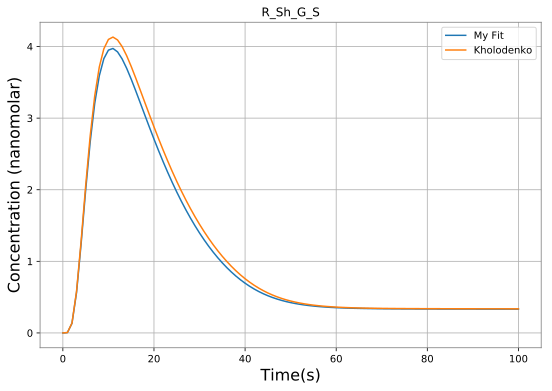

In [44]:
%config InlineBackend.figure_format = 'svg'
rcParams['figure.figsize'] = 9, 6
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='grey')

font = font_manager.FontProperties(family='Times New Roman',
                                   weight='bold',
                                   style='normal', size=11)

plt.plot(t,x[:,21], label = 'My Fit') # R_Sh_G_S
plt.plot(t,kholodenko['R_Sh_G_S | R_Sh_G_S (nanomolar)'], label = 'Kholodenko')
plt.legend(loc = 'upper right')
plt.title('R_Sh_G_S')
plt.xlabel('Time(s)',fontsize=16)
plt.ylabel('Concentration (nanomolar)',fontsize=16)
plt.grid()

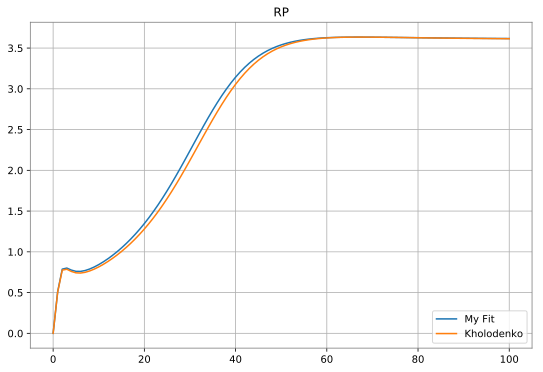

In [45]:
plt.plot(t,x[:,4], label = 'My Fit') # RP
plt.plot(t,kholodenko['RP | RP (nanomolar)'], label = 'Kholodenko')
plt.legend(loc = 'lower right')
plt.title('RP')
plt.grid()

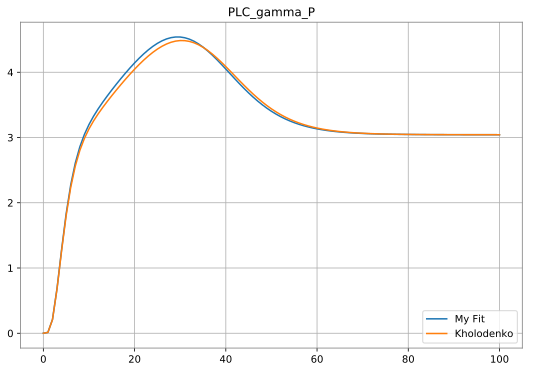

In [46]:
plt.plot(t,x[:,8], label = 'My Fit') # PLC_gamma_P
plt.plot(t,kholodenko['PLC_gamma_P | PLC_gamma_P (nanomolar)'], label = 'Kholodenko')
plt.legend(loc = 'lower right')
plt.title('PLC_gamma_P')
plt.grid()

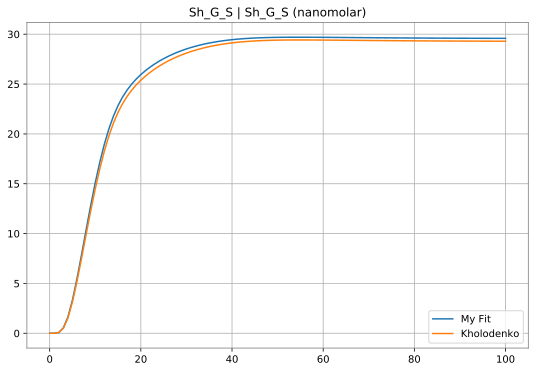

In [47]:
plt.plot(t,x[:,22], label = 'My Fit') # Sh_G_S
plt.plot(t,kholodenko['Sh_G_S | Sh_G_S (nanomolar)'], label = 'Kholodenko')
plt.legend(loc = 'lower right')
plt.title('Sh_G_S | Sh_G_S (nanomolar)')
plt.grid()

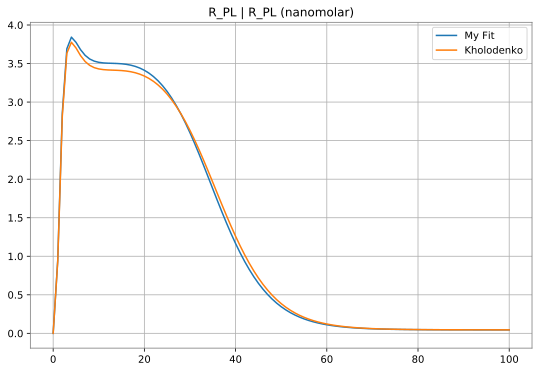

In [48]:
plt.plot(t,x[:,5], label = 'My Fit') # RPL
plt.plot(t,kholodenko['R_PL | R_PL (nanomolar)'], label = 'Kholodenko')
plt.legend(loc = 'upper right')
plt.title('R_PL | R_PL (nanomolar)')
plt.grid()

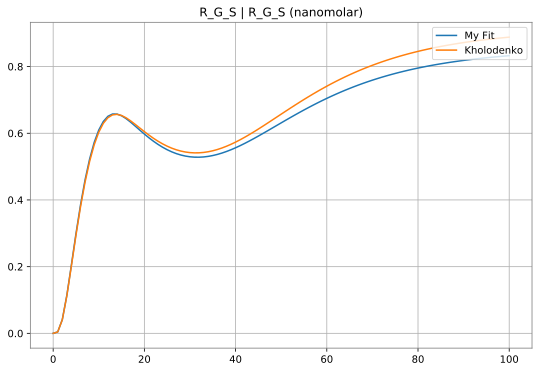

In [80]:
plt.plot(t,x[:,13], label = 'My Fit') # R_G_S
plt.plot(t,kholodenko['R_G_S | R_G_S (nanomolar)'], label = 'Kholodenko')
plt.legend(loc = 'upper right')
plt.title('R_G_S | R_G_S (nanomolar)')
plt.grid()

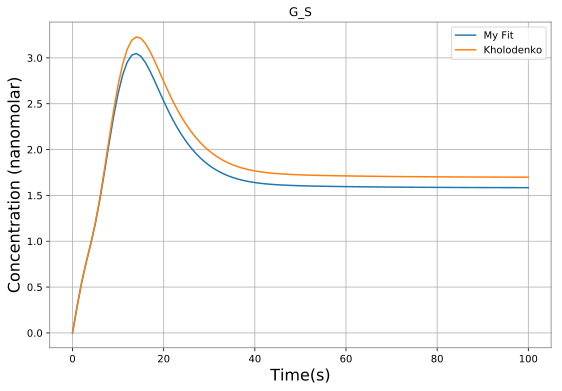

In [82]:
plt.plot(t,x[:,12], label = 'My Fit') # G_S
plt.plot(t,kholodenko['G_S | G_S (nanomolar)'], label = 'Kholodenko')
plt.legend(loc = 'upper right')
plt.title('G_S')
plt.xlabel('Time(s)',fontsize=16)
plt.ylabel('Concentration (nanomolar)',fontsize=16)
plt.grid()

In [ ]:
np.savetxt("fit_RP.csv", x[:,4], delimiter=",")   #RP
np.savetxt("fit_R_PL.csv", x[:,5], delimiter=",")   #R_PL
np.savetxt("fit_PLC_gamma_P.csv", x[:,8], delimiter=",")   #PLC_gamma_P
np.savetxt("fit_R_Sh_G_S.csv", x[:,21], delimiter=",")   #R_Sh_G_S